# CCC-Garch Model for Multivariate Volatility Forecasting

Bollerslev's Constant Conditional Correlation GARCH (CCC-GARCH) model consists of N univariate GARCH models, related to each other via a constant conditional correlation matrix R.

Key ideas of the model:
- It avoids the problem of guaranteeing positive definiteness of Sigma t by splitting it into variances and correlations.
- The conditional correlations between error terms are constant over time.
- Individual conditional variances follow a univariate GARCH(1,1) model.

In [13]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

In [3]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 1006 rows of data.


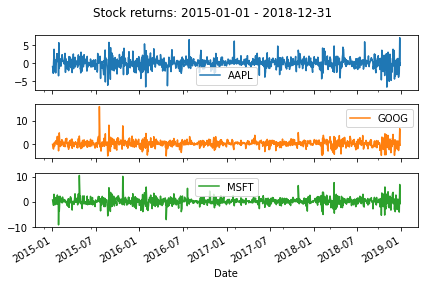

In [6]:
# Calculate daily returns

returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, 
             title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()
# plt.savefig('images/ch5_im6.png')
plt.show()

In [7]:
# Define list for storing objects

coeffs = []
cond_vol = []
std_resids = []
models = []

In [8]:
# Estimate the univariate GARCH models

for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant', 
                       vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, 
                                                       disp='off');
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

In [9]:
# Store the result in dataframes

coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                                    .set_axis(returns.columns, 
                                              axis='columns', 
                                              inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose() \
                                        .set_axis(returns.columns, 
                                                  axis='columns', 
                                                  inplace=False)

In [10]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.123494,0.221226,0.125915,0.784530
GOOG,0.080485,0.193127,0.187875,0.747864
MSFT,0.119525,0.384322,0.251946,0.625823


In [11]:
# Calculate the constant conditional correlation matrix (R)

R = std_resids_df.transpose() \
                 .dot(std_resids_df) \
                 .div(len(std_resids_df))

In [14]:
# Calculate the 1-step ahead forecast of the conditional covariance matrix

# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

c:\Users\gabrielanatalia\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\gabrielanatalia\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\gabrielanatalia\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default fo

In [15]:
H

array([[6.98990215, 3.26916864, 3.73948675],
       [3.26916864, 6.1580899 , 4.47492578],
       [3.73948675, 4.47492578, 7.51960147]])